In [1]:
import pandas as pd
import numpy as np
import deepchem as dc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Data Clean Up
We need to ensure that the same set of molecules is going to be used in each model, so we will ensure that each of the molecules has both an RDKit representation, a GraphConvMol representation, and a Mol2Vec representation.

In [2]:
df = pd.read_csv('./data/clean_henrys.csv', index_col=0)

In [24]:
df.head()

,inchikey,species_id,iupac,htype,mindhr,subcat_id,value,canonical_smiles,complexity,molecular_weight,tpsa,h_bond_acceptor_count,h_bond_donor_count,covalent_unit_count
0,AAPLIUHOKVUFCC-UHFFFAOYSA-N,4565,trimethylsilanol,M,NaN,55,0.070000,C[Si](C)(C)O,28.4,90.20,20.2,1,1,1
1,ABVVEAHYODGCLZ-UHFFFAOYSA-N,1654,1-tridecanamine,M,NaN,30,0.090000,CCCCCCCCCCCCCN,91.2,199.38,26.0,1,1,1
2,AFABGHUZZDYHJO-UHFFFAOYSA-N,87,2-methylpentane,M,960.0,11,0.000013,CCCC(C)C,21.2,86.18,0.0,0,0,1
3,AFYPFACVUDMOHA-UHFFFAOYSA-N,3670,chlorotrifluoromethane,M,2050.0,46,0.000009,C(F)(F)(F)Cl,28.4,104.46,0.0,3,0,1
4,AGDYNDJUZRMYRG-UHFFFAOYSA-N,2220,1-hexyl nitrate,M,6700.0,35,0.007600,CCCCCCO[N+](=O)[O-],89.5,147.17,55.0,3,0,1


In [219]:
rdkit_descriptors = []
graph_conv = []
m2v_smiles = []
y_vals = []
subcats = []
rdkit_featurizer = dc.feat.RDKitDescriptors()
gcn_featurizer = dc.feat.MolGraphConvFeaturizer()
for smiles, cat_id, y_val in zip(df['canonical_smiles'], df['subcat_id'], df['value']):

	# Try RDKIT featurize
	rdk = rdkit_featurizer.featurize(smiles)[0]

	if np.isnan(np.min(rdk)) or np.isnan(np.max(rdk)):
		continue

	# Get the Graph Conv 
	gcn = gcn_featurizer.featurize(smiles)[0]
	if type(gcn) != dc.feat.graph_data.GraphData:
		continue

	rdkit_descriptors.append(rdk)
	graph_conv.append(gcn)
	m2v_smiles.append(smiles)
	subcats.append(cat_id)
	y_vals.append(y_val)

Failed to featurize datapoint 0, N. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, C. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.
Failed to featurize datapoint 0, P. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


In [220]:
# Remove values with fewer than 5 examples
y_vals_sc = np.array(y_vals)[np.array(subcats) > 4]
subcats_sc = np.array(subcats)[np.array(subcats) > 4]
rdkit_descriptors_sc = np.array(rdkit_descriptors)[np.array(subcats) > 4]
graph_conv_sc = np.array(graph_conv)[np.array(subcats) > 4]
m2v_smiles_sc = np.array(m2v_smiles)[np.array(subcats) > 4]

In [221]:
print("Min: ", min(y_vals_sc))
print("Max: ", max(y_vals_sc))

Min:  1.2e-07
Max:  23000000000.0


In [222]:
# Log transform on the y values
y_log = np.log10(y_vals_sc)

In [246]:
# List of descriptors:
rdkit_featurizer.descriptors

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_

# Model 1 - Using RDKit Descriptors.

In [223]:
# Split into a train/test set, stratified on categories
X_train, X_test, y_train, y_test = train_test_split(rdkit_descriptors_sc, y_log, test_size=0.2, random_state=42)

In [224]:
# Try a random forest regressor
rf = RandomForestRegressor()

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.8728845415775468

In [225]:
# Try a ridge regression
lm = Ridge(1)

lm.fit(X_train, y_train)

lm.score(X_test, y_test)

0.8120724627817979

In [226]:
knn = KNeighborsRegressor(5)

knn.fit(X_train, y_train)

knn.score(X_test, y_test)

0.5954115029738744

## Fine tuning the random forest model
We are going to look at adjusting the number of iterators and decreasing the number of max splits to see if model performance can be improved.

In [231]:
# Split the training data using KFold
from sklearn.model_selection import KFold

folds = KFold(n_splits=4, shuffle=True, random_state=42)

num_ests = [100, 200, 300]
r2_scores = []

for n in num_ests:
	n_est_r2_score = []
	for train_idx, val_idx in folds.split(X_train):
		X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
		y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

		rf = RandomForestRegressor(n_estimators=n)

		rf.fit(X_train_fold, y_train_fold)

		n_est_r2_score.append(rf.score(X_val_fold, y_val_fold))

	r2_scores.append(np.mean(n_est_r2_score))

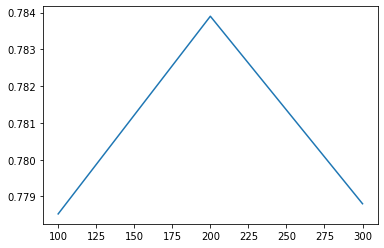

In [232]:
plt.plot(num_ests, r2_scores)

In [237]:
# Split the training data using KFold
from sklearn.model_selection import KFold

folds = KFold(n_splits=4, shuffle=True, random_state=42)

max_depths = [3, 5, 10, 15]
r2_scores = []

for n in max_depths:
	n_est_r2_score = []
	for train_idx, val_idx in folds.split(X_train):
		X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
		y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

		rf = RandomForestRegressor(n_estimators=200, max_depth=n)

		rf.fit(X_train_fold, y_train_fold)

		n_est_r2_score.append(rf.score(X_val_fold, y_val_fold))

	r2_scores.append(np.mean(n_est_r2_score))

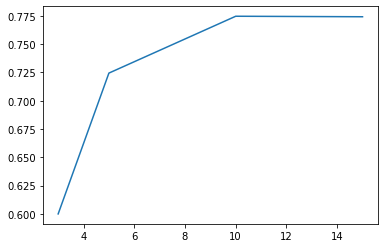

In [236]:
plt.plot(max_depths, r2_scores)

In [243]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10)

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.8693850727437107

In [244]:
# Mean squared error
mean_squared_error(y_test, rf.predict(X_test))

0.5028213113134737

In [245]:
print("R2 on train: ", rf.score(X_train, y_train))
print("MSE on train: ", mean_squared_error(y_train, rf.predict(X_train)))

R2 on train:  0.9666431709243358
MSE on train:  0.1253848936092277


# Supplemental Material
I want to look at the principal components between the values as well as the principal components only within one subcategory.

In [207]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)

pca_all = pca1.fit_transform(rdkit_descriptors_sc)

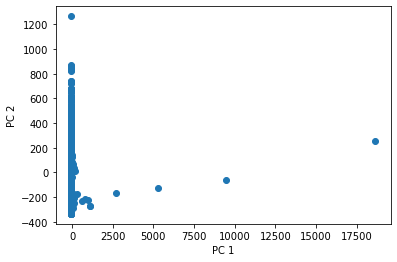

In [210]:
fig = plt.figure()
plt.scatter(pca_all[:, 0], pca_all[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()
fig.savefig("PCA_all.png")

In [211]:
one_cat = np.array(rdkit_descriptors)[np.array(subcats) == 40]

pca2 = PCA(n_components=2)
pca_one = pca2.fit_transform(one_cat)
pca_all2 = pca2.transform(rdkit_descriptors_sc)

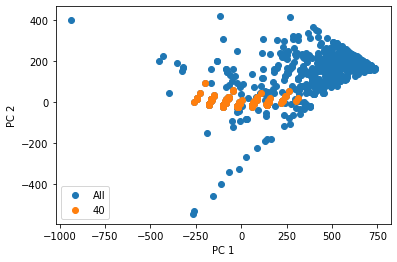

In [213]:
fig = plt.figure()
plt.scatter(pca_all2[:, 0], pca_all2[:, 1], label='All')
plt.scatter(pca_one[:, 0], pca_one[:, 1], label='40')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()
fig.savefig("PCA_subcat40.png")

In [200]:
one_cat.shape

(130, 208)

In [ ]:
o